# Abusif content classification

In [1]:
# import libraries 
import pandas as pd
# pd take screen width
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
%matplotlib inline


In [2]:
arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations = arabic_punctuations + english_punctuations


def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text


def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

# def remove_emoji(text):
#     return emoji.get_emoji_regexp().sub(u'', text)

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

#elongation
def normalization(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in arabic_stopwords]
    return ' '.join(filtered_sentence)

#cleaning function
def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')


    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    line=remove_diacritics(normalization(line))
    return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [3]:
# read the data
annotated_data = pd.read_csv('/kaggle/input/racism/All_Data_Racism.csv')
#scrapped_data = pd.read_csv('/kaggle/input/offensive-content/final_dataset.csv', encoding='utf-16')

annotated_data

,text,label
0,معتوه يحاول استثمار العنصريه اجل الفوز الشخص اجر قطعه ارض منهاتن نيورك للقذافي زيارته لتلك المدينه اجل نصب فيها خيمته واليوم هو يتنكر للعرب والمسلمين,Racism
1,كول هذا هوا خنزير الخنازير اما الصهاينه نهايتهم للدعس تفه,Racism
2,واش هي منيتكم اشوف الزمر تشطح السيده منصور معاها اشنو كاي الهدف هادشي,not racism
3,كسم السيسي علي كسم ال دعم السيسي يوم حتي دنا كنت اعدادي بشخه واقول للعيال الدروس العسكري هينيكك وينهبك زي مب بقاله 60 سنه بيعمل ايه واله بيبداها دم مستحيل تشوف خير كانوا يتنمروا عليا ويقولوا عليا اخوان ولاد الاحبه نصهم اهاليهم بتشحت دلوقت,Racism
4,السعوديه هي اطهر ارض وشعب واحقر شعب,Racism
...,...,...
1881,ان الله غفور رحيم كلنا عندنا عيوبنا داك الشماته اللي صور الفيديو سير الله يفضحك دنيا واخيره,not racism
1882,الجراءم مدعومه حكام الخلبج,not racism
1883,اساسا انتم تدرون ان سلاطين اراضيكم الجاهليه ماضغطونا اظن والله اعلم ان كلمه ساضغط مشتقه ضغط الجزيره مرتفع وظهرت بسببه الكلمه,Racism
1884,مخلفات الدوله العبيديه مصر تغني الصيام والعباده جزء الشعاءر,Racism


In [4]:
# drop nan values
print( f" length of annotated_data : {len(annotated_data)}")
annotated_data['label'].value_counts()

 length of annotated_data : 1886


not racism    1050
Racism         836
Name: label, dtype: int64

In [5]:
data = annotated_data.copy()
# clean the data
data['text'] = data['text'].apply(cleaning_content)
print(data['label'].value_counts())
data

not racism    1050
Racism         836
Name: label, dtype: int64


,text,label
0,معتوه يحاول استثمار العنصريه اجل الفوز الشخص اجر قطعه ارض منهاتن نيورك للقذافي زيارته لتلك المدينه اجل نصب خيمته واليوم يتنكر للعرب والمسلمين,Racism
1,كول هوا خنزير الخنازير اما الصهاينه نهايتهم للدعس تفه,Racism
2,واش منيتكم اشوف الزمر تشطح السيده منصور معاها اشنو كاي الهدف هادشي,not racism
3,كسم السيسي علي كسم ال دعم السيسي يوم حتي دنا كنت اعدادي بشخه واقول للعيال الدروس العسكري هينيكك وينهبك زي مب بقاله 60 سنه بيعمل ايه واله بيبداها دم مستحيل تشوف خير كانوا يتنمروا عليا ويقولوا عليا اخوان ولاد الاحبه نصهم اهاليهم بتشحت دلوقت,Racism
4,السعوديه اطهر ارض وشعب واحقر شعب,Racism
...,...,...
1881,ان الله غفور رحيم كلنا عندنا عيوبنا داك الشماته اللي صور الفيديو سير الله يفضحك دنيا واخيره,not racism
1882,الجراءم مدعومه حكام الخلبج,not racism
1883,اساسا انتم تدرون ان سلاطين اراضيكم الجاهليه ماضغطونا اظن والله اعلم ان كلمه ساضغط مشتقه ضغط الجزيره مرتفع وظهرت بسببه الكلمه,Racism
1884,مخلفات الدوله العبيديه مصر تغني الصيام والعباده جزء الشعاءر,Racism


In [6]:
data.label.unique()

array(['Racism', 'not racism'], dtype=object)

              precision    recall  f1-score   support

      Racism       0.84      0.87      0.85       160
  not racism       0.90      0.88      0.89       218

    accuracy                           0.87       378
   macro avg       0.87      0.87      0.87       378
weighted avg       0.87      0.87      0.87       378



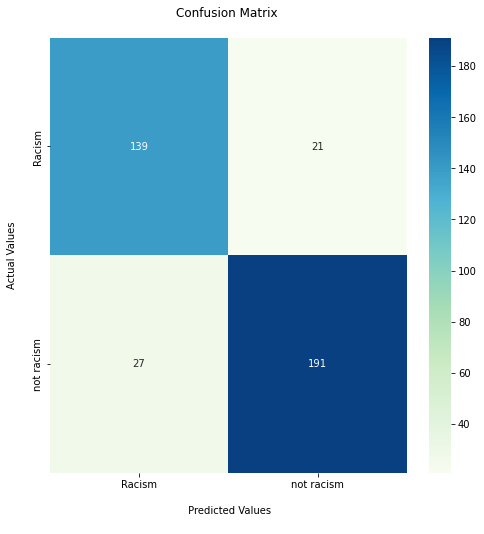

In [7]:
# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# vectorize the data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# train the model
from sklearn.naive_bayes import MultinomialNB

MNB_model = MultinomialNB().fit(X_train, y_train)

# test the model
predicted_mnb = MNB_model.predict(X_test)

# evaluate the model
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_mnb))
probs_mnb = MNB_model.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_mnb), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()



              precision    recall  f1-score   support

      Racism       0.84      0.90      0.87       160
  not racism       0.92      0.88      0.90       218

    accuracy                           0.89       378
   macro avg       0.88      0.89      0.88       378
weighted avg       0.89      0.89      0.89       378



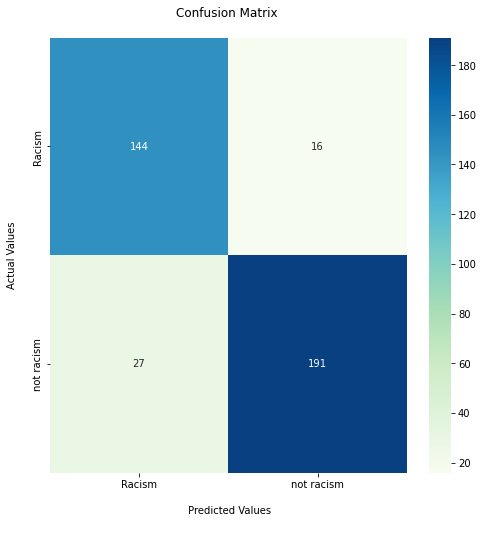

In [8]:
# Trying svm
from sklearn import svm
svm_model = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)
predicted_svm = svm_model.predict(X_test)
print(metrics.classification_report(y_test, predicted_svm))

# print probabilities
probs_svm = svm_model.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_svm), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()


              precision    recall  f1-score   support

      Racism       0.84      0.87      0.85       160
  not racism       0.90      0.88      0.89       218

    accuracy                           0.87       378
   macro avg       0.87      0.87      0.87       378
weighted avg       0.87      0.87      0.87       378



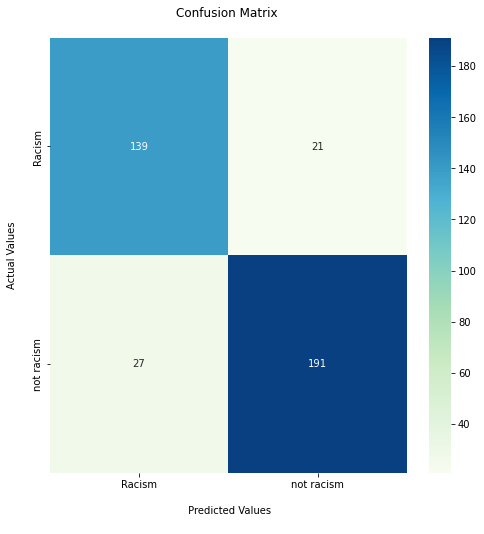

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
DTC = DecisionTreeClassifier().fit(X_train, y_train)

# Make predictions on the test data
predicted_DTC = DTC.predict(X_test)

print(metrics.classification_report(y_test, predicted_DTC))

# print probabilities
probs_dtc = DTC.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_DTC), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()


              precision    recall  f1-score   support

      Racism       0.92      0.89      0.91       160
  not racism       0.92      0.94      0.93       218

    accuracy                           0.92       378
   macro avg       0.92      0.92      0.92       378
weighted avg       0.92      0.92      0.92       378



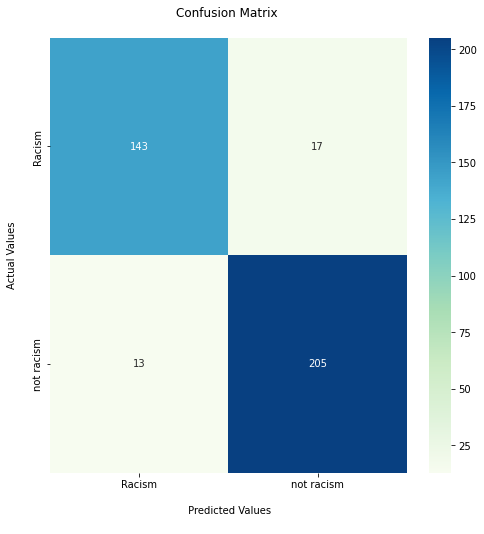

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
RFC = RandomForestClassifier().fit(X_train, y_train)
predicted_RFC = RFC.predict(X_test)
print(metrics.classification_report(y_test, predicted_RFC))
# Make predictions on the test data
probs_rfc = RFC.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_RFC), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()


              precision    recall  f1-score   support

      Racism       0.90      0.91      0.90       160
  not racism       0.93      0.92      0.93       218

    accuracy                           0.92       378
   macro avg       0.91      0.91      0.91       378
weighted avg       0.92      0.92      0.92       378



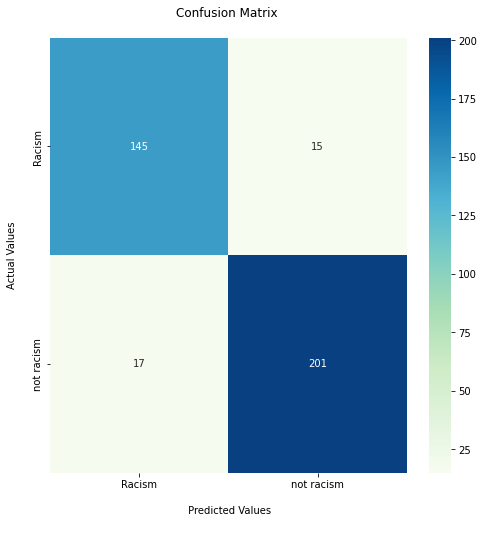

In [11]:
from sklearn.svm import SVC

# Initialize the classifier
SVC = SVC(probability=True).fit(X_train, y_train)
predicted_SVC = SVC.predict(X_test)
print(metrics.classification_report(y_test, predicted_SVC))
# Make predictions on the test data
probs_svc = SVC.predict_proba(X_test)

#confusion matrix
plt.figure(figsize=(8,8))
fx=sns.heatmap(metrics.confusion_matrix(y_test, predicted_SVC), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'].unique())
fx.yaxis.set_ticklabels(data['label'].unique())
plt.show()


In [14]:
# # balance the data
# data = data.groupby('label').apply(lambda x: x.sample(1305, replace=True)).reset_index(drop=True)

# data.label.value_counts()

## LSTM

In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

ModuleNotFoundError: No module named 'keras'

In [ ]:
data

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


In [ ]:
Y = pd.get_dummies(data['label']).values
print('Shape of label tensor:', Y.shape)
Y

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

from keras.layers import BatchNormalization, GlobalMaxPooling1D
lstm = Sequential()
lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
lstm.add(BatchNormalization())
lstm.add(LSTM(100, return_sequences=True))
lstm.add(LSTM(100, return_sequences=True))
lstm.add(LSTM(100))
lstm.add(Dense(100, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(2, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm.summary())

In [ ]:
epochs = 40
batch_size = 64

history = lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.25,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
X_test.shape,Y_test.shape

In [ ]:
accr = lstm.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
new_complaint = ['ولك يا حمار اسكت و ريحنا منك ولو ها المرة بس']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = lstm.predict(padded)
labels = ['verbal abuse','none']
print(pred, labels[np.argmax(pred)])

## Arabert

### Preprocessing and Cleaning

In [12]:
def remove_hashtag(df, col = 'text'):
    for letter in r'#.][!XR':
        df[col] = df[col].astype(str).str.replace(letter,'', regex=True)
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
from nltk.stem.isri import ISRIStemmer
import re

stemmer = ISRIStemmer()
def processDocument(doc, stemmer): 

    #Replace @username with empty string
    doc = re.sub(r'@[^\s]+', ' ', doc)
    doc = re.sub(r'_', ' ', doc)
    doc = re.sub(r'\n', ' ', doc)
    doc = re.sub(r'\r', ' ', doc)
    doc = re.sub(r':///', ' ', doc)
    doc = re.sub(r'///:', ' ', doc)
    doc = re.sub(r'مستخدم@', ' ', doc)
    doc = re.sub(r'[a-z,A-Z]', ' ', doc)
    doc = re.sub(r'\d', '', doc)
    #Convert www.* or https?://* to " "
    doc = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',doc)
    #Replace #word with word
    doc = re.sub(r'#([^\s]+)', r'\1', doc)
    # remove punctuations
    # normalize the tweet
#     doc= normalize_arabic(doc)
    # remove repeated letters
#     doc=remove_repeating_char(doc)
    #stemming
#     doc = stemmer.stem(doc)
   
    return doc

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


In [13]:
import pyarabic.araby as araby
frame=annotated_data
frame=frame.drop_duplicates()
remove_hashtag(frame)
frame["text"] = frame['text'].apply(lambda x: araby.strip_diacritics(x))
frame["text"] = frame['text'].apply(lambda x: normalize_arabic(x))
frame["text"] = frame['text'].apply(lambda x: processDocument(x, stemmer))
frame["text"] = frame['text'].apply(lambda x: deEmojify(x))

frame

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,text,label
0,معتوه يحاول استثمار العنصريه اجل الفوز الشخص اجر قطعه ارض منهاتن نيورك للقذافي زيارته لتلك المدينه اجل نصب فيها خيمته واليوم هو يتنكر للعرب والمسلمين,Racism
1,كول هذا هوا خنزير الخنازير اما الصهاينه نهايتهم للدعس تفه,Racism
2,واش هي منيتكم اشوف الزمر تشطح السيده منصور معاها اشنو كاي الهدف هادشي,not racism
3,كسم السيسي علي كسم ال دعم السيسي يوم حتي دنا كنت اعدادي بشخه واقول للعيال الدروس العسكري هينيكك وينهبك زي مب بقاله سنه بيعمل ايه واله بيبداها دم مستحيل تشوف خير كانوا يتنمروا عليا ويقولوا عليا اخوان ولاد الاحبه نصهم اهاليهم بتشحت دلوقت,Racism
4,السعوديه هي اطهر ارض وشعب واحقر شعب,Racism
...,...,...
1881,ان الله غفور رحيم كلنا عندنا عيوبنا داك الشماته اللي صور الفيديو سير الله يفضحك دنيا واخيره,not racism
1882,الجراءم مدعومه حكام الخلبج,not racism
1883,اساسا انتم تدرون ان سلاطين اراضيكم الجاهليه ماضغطونا اظن والله اعلم ان كلمه ساضغط مشتقه ضغط الجزيره مرتفع وظهرت بسببه الكلمه,Racism
1884,مخلفات الدوله العبيديه مصر تغني الصيام والعباده جزء الشعاءر,Racism


In [14]:
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [20]:
import joblib

data = frame.copy()
y = data.label.values
encodedict = {'not racism': 0, 'Racism': 1}
y = np.array([encodedict[item] for item in y])

data['label'] = y

train, val = train_test_split(data[['label','text']], test_size=0.2, random_state=42)


In [21]:
train['label'].value_counts(),val['label'].value_counts()

(0    811
 1    676
 Name: label, dtype: int64,
 0    221
 1    151
 Name: label, dtype: int64)

In [28]:
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)

In [22]:
class ArabicDataset(Dataset):
    def __init__(self,data,max_len,model_type="Mini"):
        super().__init__()
        self.labels = data["label"].values
        self.texts = data["text"].values
        self.max_len = max_len
        model = {"Mini": "asafaya/bert-mini-arabic",
                "Medium": "asafaya/bert-medium-arabic",
                "Base": "asafaya/bert-base-arabic",
                "Large": "asafaya/bert-large-arabic"}
        self.tokenizer = AutoTokenizer.from_pretrained(model[model_type])
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,idx):
        text = " ".join(self.texts[idx].split())
        label = self.labels[idx]
        inputs = self.tokenizer(text,padding='max_length',
                                max_length=self.max_len,truncation=True,return_tensors="pt")
        #input_ids,token_type_ids,attention_mask
        return {
            "inputs":{"input_ids":inputs["input_ids"][0],
                      "token_type_ids":inputs["token_type_ids"][0],
                      "attention_mask":inputs["attention_mask"][0],
                     },
            "labels": torch.tensor(label,dtype=torch.long) 
        }

In [23]:
class ArabicBertModel(pl.LightningModule):
    def __init__(self,model_type="Mini"):
        super().__init__()
        model = {"Mini": ("asafaya/bert-mini-arabic",256),
                "Medium": ("asafaya/bert-medium-arabic",512),
                "Base": ("asafaya/bert-base-arabic",768),
                "Large": ("asafaya/bert-large-arabic",1024)}
        self.bert_model = AutoModel.from_pretrained(model[model_type][0])
        self.fc = nn.Linear(model[model_type][1],18)
    
    def forward(self,inputs):
        out = self.bert_model(**inputs)#inputs["input_ids"],inputs["token_type_ids"],inputs["attention_mask"])
        pooler = out[1]
        out = self.fc(pooler)
        return out
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)
    
    def criterion(self,output,target):
        return nn.CrossEntropyLoss()(output,target)
    
    #TODO: adding metrics
    def training_step(self,batch,batch_idx):
        x,y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        return loss

In [24]:
class ArabicDataModule(pl.LightningDataModule):
    def __init__(self,train_path,val_path,batch_size=12,max_len=100,model_type="Mini"):
        super().__init__()
        self.train_path,self.val_path= train_path,val_path
        self.batch_size = batch_size
        self.max_len = max_len
        self.model_type = model_type
    
    def setup(self,stage=None):
        train = pd.read_csv(self.train_path)
        val = pd.read_csv(self.val_path)
        self.train_dataset = ArabicDataset(data=train,max_len=self.max_len,model_type=self.model_type)
        self.val_dataset = ArabicDataset(data=val,max_len=self.max_len,model_type=self.model_type)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=4)

### callbacks

In [25]:
import torch
from torch import nn,optim

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [26]:
! nvidia-smi

Sun Jan  8 13:53:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
#TODO: getting different models sizes results
MODEL_TYPE = "Medium"
dm = ArabicDataModule(train_path="./train.csv",
                val_path = "./val.csv",
                batch_size=128,max_len=60, model_type=MODEL_TYPE)

model = ArabicBertModel(model_type=MODEL_TYPE)
#trainer = pl.Trainer(accelerator='gpu', devices=1,max_epochs=20, default_root_dir='.')
trainer = pl.Trainer(accelerator='gpu', devices=1,max_epochs = 20, default_root_dir='.')
trainer.fit(model,dm)

Some weights of the model checkpoint at asafaya/bert-medium-arabic were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1599: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [30]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
real_values = []

load = ArabicDataModule(train_path="./train.csv",
                           val_path = "./val.csv",
                batch_size=512,max_len=60)
load.setup()
train_dataloader = load.train_dataloader()

progress_bar = tqdm(range(len(train_dataloader)))

model.eval()
for batch in train_dataloader:    
    x,y = batch["inputs"],batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}
    
    with torch.no_grad():
        outputs = model(inp)

    predictions = torch.argmax(outputs, dim=-1)
    
    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()
    
preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
from sklearn.metrics import classification_report

print(classification_report(real_values, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       811
           1       0.99      1.00      0.99       676

    accuracy                           0.99      1487
   macro avg       0.99      0.99      0.99      1487
weighted avg       0.99      0.99      0.99      1487



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (1859).

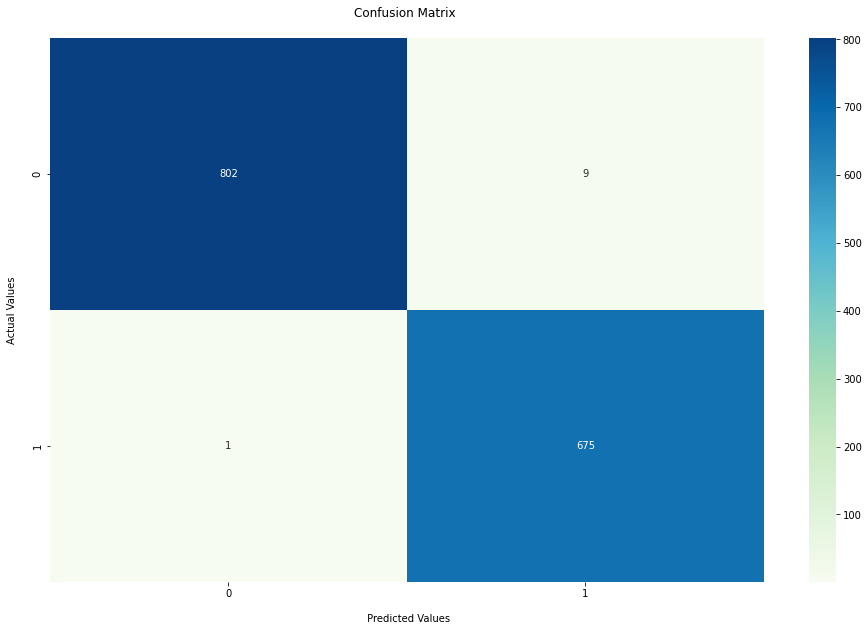

In [36]:
import sklearn.metrics as metrics

plt.figure(figsize=(16,10))
fx=sns.heatmap(metrics.confusion_matrix(real_values, preds), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'])
fx.yaxis.set_ticklabels(data['label'])
plt.show()

In [37]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
real_values = []

load = ArabicDataModule(train_path="./train.csv",
                           val_path = "./val.csv",
                batch_size=512,max_len=60)
load.setup()
test_dataloader = load.val_dataloader()

progress_bar = tqdm(range(len(test_dataloader)))

model.eval()
for batch in test_dataloader:    
    x,y = batch["inputs"],batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}
    
    with torch.no_grad():
        outputs = model(inp)

    predictions = torch.argmax(outputs, dim=-1)
    
    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()
    
preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
from sklearn.metrics import classification_report

print(classification_report(real_values, preds))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       221
           1       0.87      0.93      0.90       151

    accuracy                           0.92       372
   macro avg       0.91      0.92      0.91       372
weighted avg       0.92      0.92      0.92       372



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (1859).

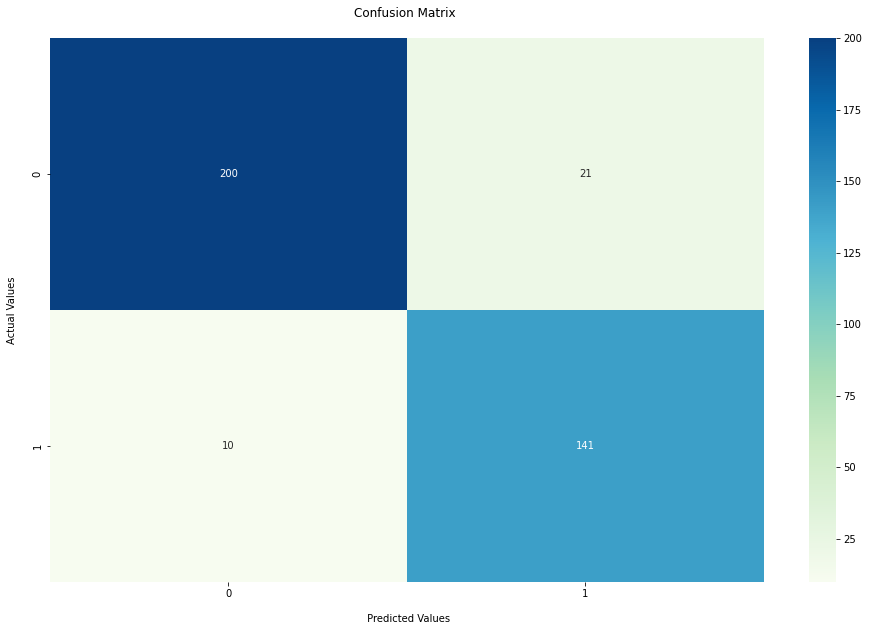

In [39]:
import sklearn.metrics as metrics

plt.figure(figsize=(16,10))
fx=sns.heatmap(metrics.confusion_matrix(real_values, preds), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(data['label'])
fx.yaxis.set_ticklabels(data['label'])
plt.show()

In [40]:
torch.save(model.state_dict(),'racism_arabert.pt')

In [ ]:
# import pickle

# # Save the model
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# # Load the model
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)